# **Title: Project Network Analysys: 2-Node Networks**

---



**Submitted by:** Umais Siddiqui, Banu Boopalan

**Date:** March 17th, 2025

**Course:** Data Science – DATA620

**Video Link:** https://www.youtube.com/watch?v=ejxjR8XgWVA

**Github Repository:** https://github.com/umais/DATA620/blob/master/Project2/Project2_2Node_Network_analysis.ipynb

In this project we will be inferring about the relationships between (1) the actors, and (2) the movies from this simple 2-node network dataset where the two nodes are:

##**Nodes:**
- Actors:  individuals who acted in various movies.
- Movies: 13 different movies with appearance by one or more actor.


##**Edges:**

- The relationships between Actor and Movies are represented by edges. Each edge indicates that a particular actor acted in a particular movie. If there’s no edge, that actor did not act in that movie.

Graph Representation:

This is a bipartite network, meaning it connects two distinct types of nodes (Actors and movies), and the edges show which Actors participated in which movie.

#**Load Data and Plot the Bipartite Graph (Actor & Movies)**

- Load the data from the TMDB API using the API Key

- List out the Movies of Interest

- Generate the Graph based on Actor and Movie

- Detect the bipartite two node set

- Draw the Bi Partite Graph

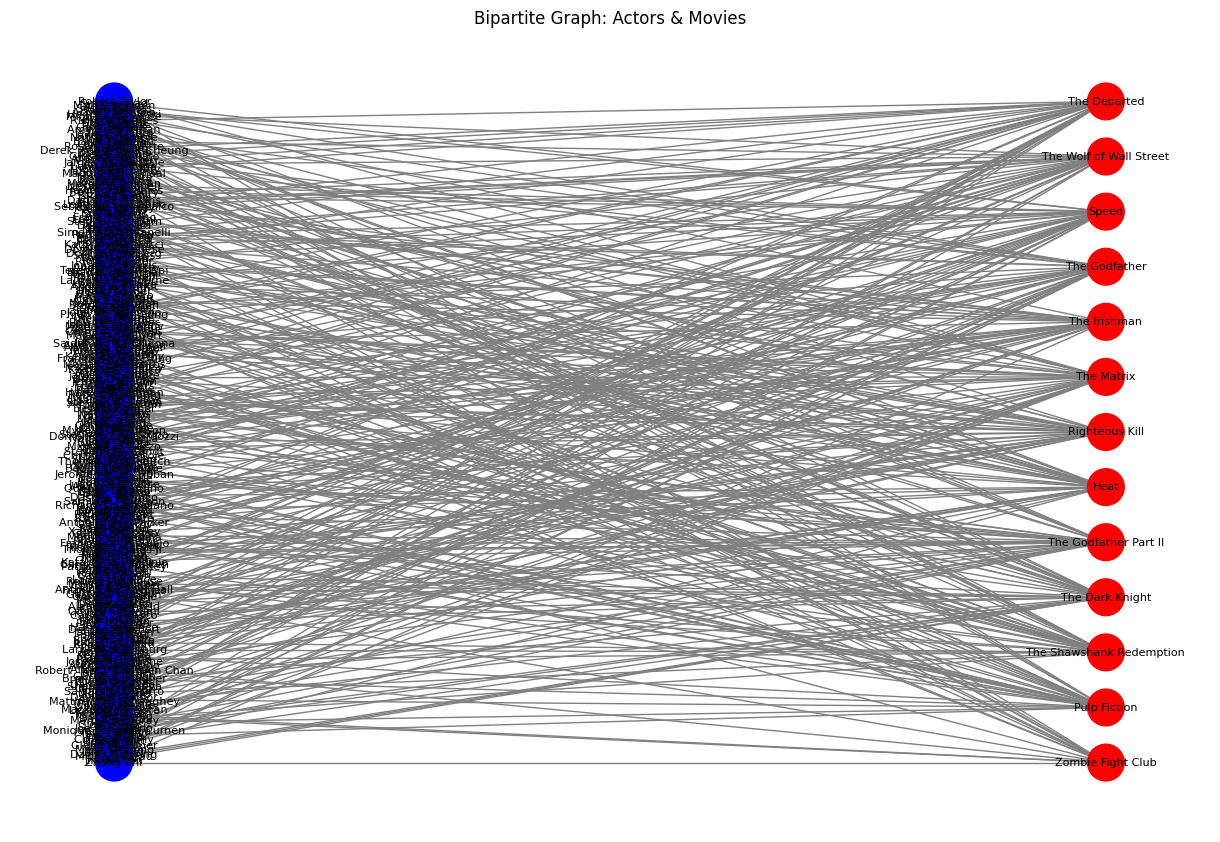

In [9]:
import requests
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms import bipartite

import community.community_louvain as community_louvain
API_KEY = "73c8ff872a8c6ffd83817caee254c0f3"
BASE_URL = "https://api.themoviedb.org/3/"

def get_movies_by_name(movie_names):
    movie_ids = []
    for name in movie_names:
        url = f"{BASE_URL}search/movie?api_key={API_KEY}&query={name}"
        response = requests.get(url)
        if response.status_code == 200:
            results = response.json().get("results", [])
            if results:
                movie_ids.append((results[0]["id"], results[0]["title"]))
    return movie_ids

def get_movie_data(movie_id):
    url = f"{BASE_URL}movie/{movie_id}/credits?api_key={API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    return None

def create_bipartite_graph(movie_names):
    B = nx.Graph()
    actor_movie_count = {}  # Track number of movies per actor
    movie_data = get_movies_by_name(movie_names)

    for movie_id, movie_title in movie_data:
        data = get_movie_data(movie_id)
        if data and "cast" in data:
            B.add_node(movie_title, bipartite=1, color='red')
            for cast in data["cast"][:30]:  # Increase to 30 actors per movie
                actor_name = cast["name"]
                B.add_node(actor_name, bipartite=0, color='blue')
                B.add_edge(actor_name, movie_title)
                actor_movie_count[actor_name] = actor_movie_count.get(actor_name, 0) + 1  # Count appearances

    return B, actor_movie_count

def draw_bipartite_graph(B):
    """Visualizes the bipartite graph with actors and movies."""
    plt.figure(figsize=(12, 8))

    # Extract actor and movie sets
    actors = {node for node, data in B.nodes(data=True) if data["bipartite"] == 0}
    movies = set(B) - actors

    # Get layout for bipartite graph
    pos = nx.bipartite_layout(B, actors)

    # Assign colors
    node_colors = ['blue' if node in actors else 'red' for node in B.nodes()]

    # Draw graph
    nx.draw(B, pos, with_labels=True, node_color=node_colors, edge_color='gray', font_size=8, node_size=700)

    plt.title("Bipartite Graph: Actors & Movies")
    plt.show()

def find_top_actors(actor_movie_count, top_n=10):
    """Find the top N actors who appeared in the most movies."""
    sorted_actors = sorted(actor_movie_count.items(), key=lambda x: x[1], reverse=True)
    return [actor for actor, count in sorted_actors[:top_n]]

def build_top_actor_network(B, top_actors):
    """Create a network of the top actors, connecting them if they appeared in the same movie."""
    G = nx.Graph()

    # Add top actors as nodes
    for actor in top_actors:
        G.add_node(actor)

    # Connect actors who appeared in the same movie
    for movie in [node for node, data in B.nodes(data=True) if data["bipartite"] == 1]:
        actors_in_movie = [actor for actor in B.neighbors(movie) if actor in top_actors]
        for i in range(len(actors_in_movie)):
            for j in range(i + 1, len(actors_in_movie)):
                G.add_edge(actors_in_movie[i], actors_in_movie[j])

    return G

def detect_communities(G):
    """Detects communities using Louvain method."""
    if G.number_of_edges() > 0:
        partition = community_louvain.best_partition(G)
    else:
        partition = {node: 0 for node in G.nodes()}  # If no connections, assign all to one group
    return partition

def draw_actor_community(G, partition):
    """Visualizes the actor network with detected communities."""
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42)
    colors = [partition[node] for node in G.nodes()]
    nx.draw(G, pos, with_labels=True, node_color=colors, cmap=plt.cm.rainbow, node_size=2000, font_size=10)
    plt.title("Top Actors Community Network")
    plt.show()

def apply_island_method(actor_network, B, min_movies=2):
    """Applies the island method by removing actors with fewer than min_movies appearances."""
    # Compute actor degree (number of movies they acted in)
    actor_degrees = {actor: len(B[actor]) for actor in actor_network.nodes()}

    # Filter actors who appeared in at least 'min_movies'
    strong_actors = {actor for actor, degree in actor_degrees.items() if degree >= min_movies}

    # Create a subgraph with only strong actors
    island_network = actor_network.subgraph(strong_actors).copy()

    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(island_network, seed=42)

    # Draw the filtered network
    nx.draw(island_network, pos, with_labels=True, node_color="skyblue", edge_color='gray',
            node_size=2000, font_size=10)

    # Highlight top actors in orange
    nx.draw_networkx_nodes(island_network, pos, node_color="orange", node_size=2500)

    plt.title(f"Island Network: Actors in {min_movies}+ Movies")
    plt.show()

    return island_network

def compute_centrality_measures(actor_network):
    """Compute and display centrality measures for the actor network."""

    # Calculate centrality measures
    degree_centrality = nx.degree_centrality(actor_network)
    betweenness_centrality = nx.betweenness_centrality(actor_network)
    closeness_centrality = nx.closeness_centrality(actor_network)
    eigenvector_centrality = nx.eigenvector_centrality(actor_network, max_iter=1000)


# Create DataFrame for centrality measures
    centrality_df = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'Betweenness Centrality': betweenness_centrality,
    'Closeness Centrality': closeness_centrality,
    'Eigenvector Centrality': eigenvector_centrality
}).sort_values(by='Degree Centrality', ascending=False)

    # Convert to sorted lists (descending order)
    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

    # Print Top 10 for each measure
    print("\n🔹 Top 10 Actors by Degree Centrality:")
    for actor, score in top_degree:
        print(f"{actor}: {score:.4f}")

    print("\n🔹 Top 10 Actors by Betweenness Centrality:")
    for actor, score in top_betweenness:
        print(f"{actor}: {score:.4f}")

    print("\n🔹 Top 10 Actors by Closeness Centrality:")
    for actor, score in top_closeness:
        print(f"{actor}: {score:.4f}")

    print("\n🔹 Top 10 Actors by Eigenvector Centrality:")
    for actor, score in top_eigenvector:
        print(f"{actor}: {score:.4f}")

    return top_degree, top_betweenness, top_closeness, top_eigenvector,centrality_df



# Define movie list
movie_names = [
    "Fight Club", "Pulp Fiction", "The Shawshank Redemption", "The Dark Knight", "The Godfather Part II", "Heat",
    "Righteous Kill", "The Matrix", "The Irishman", "The Godfather","Speed","The Wolf of Wall Street","The Departed"
]

# Step 1: Create bipartite graph and count actor appearances
B, actor_movie_count = create_bipartite_graph(movie_names)
draw_bipartite_graph(B)
# Step 2: Find top actors
top_actors = find_top_actors(actor_movie_count, top_n=10)



#Detecting Community Of Actors with Most Movies

Top 10 Actors with Most Movie Appearances: ['Al Pacino', 'Robert De Niro', 'Harvey Keitel', 'Morgan Freeman', 'Mark Rolston', 'William Fichtner', 'Robert Duvall', 'Diane Keaton', 'John Cazale', 'Talia Shire']


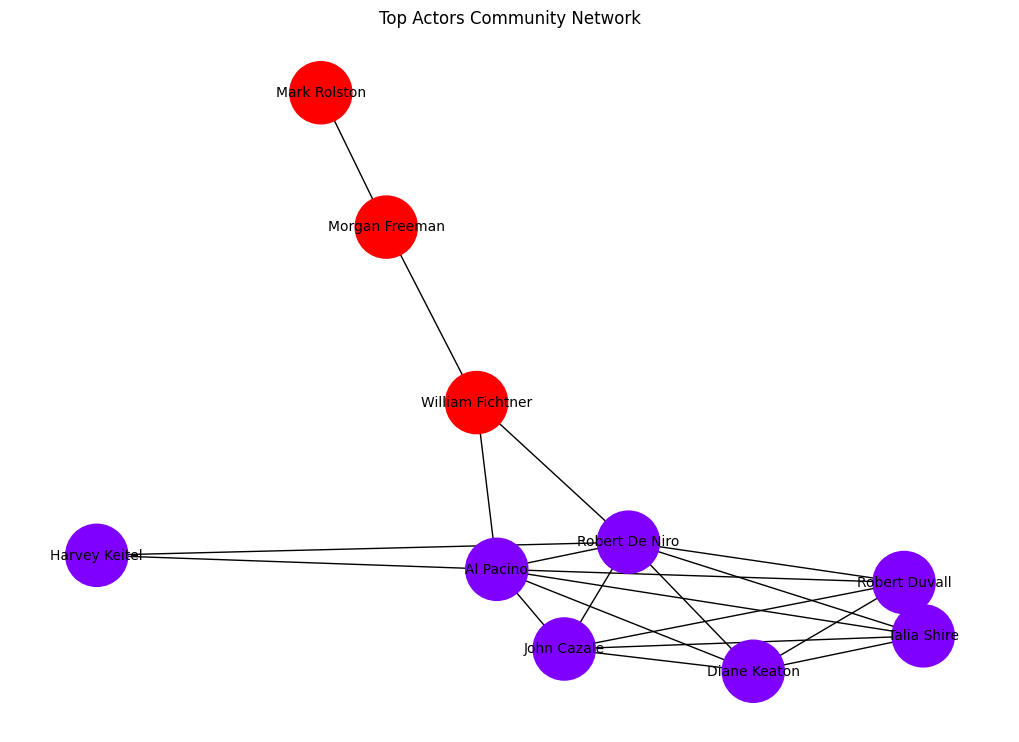

Actor community detection completed.


In [10]:
print("Top 10 Actors with Most Movie Appearances:", top_actors)

# Step 3: Build top actor network
top_actor_network = build_top_actor_network(B, top_actors)

# Step 4: Detect and visualize communities
actor_partition = detect_communities(top_actor_network)
draw_actor_community(top_actor_network, actor_partition)

print("Actor community detection completed.")

#Island Method

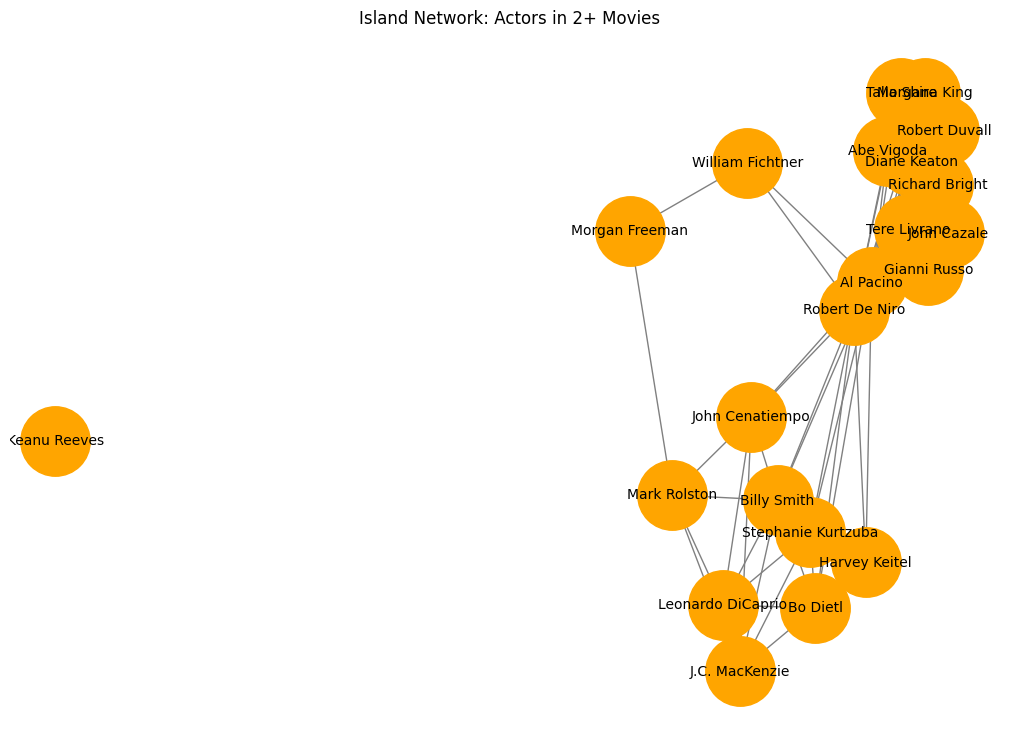

In [11]:


# Generate actor network from bipartite graph
actors = {node for node, data in B.nodes(data=True) if data["bipartite"] == 0}
actor_network = bipartite.weighted_projected_graph(B, actors)

# Apply the island method (filter out actors with fewer than 2 movies)
island_network = apply_island_method(actor_network, B, min_movies=2)


Centrality MEasures

In [14]:
# Compute centrality measures on the filtered island network
compute_centrality_measures(island_network)

# @title Degree Centrality




🔹 Top 10 Actors by Degree Centrality:
Al Pacino: 0.7619
Robert De Niro: 0.7619
Robert Duvall: 0.4762
Talia Shire: 0.4762
John Cazale: 0.4762
Abe Vigoda: 0.4762
Morgana King: 0.4762
Diane Keaton: 0.4762
Tere Livrano: 0.4762
Richard Bright: 0.4762

🔹 Top 10 Actors by Betweenness Centrality:
Al Pacino: 0.2374
Robert De Niro: 0.2374
Billy Smith: 0.0726
William Fichtner: 0.0594
John Cenatiempo: 0.0545
Stephanie Kurtzuba: 0.0315
Bo Dietl: 0.0315
Mark Rolston: 0.0274
Leonardo DiCaprio: 0.0070
J.C. MacKenzie: 0.0070

🔹 Top 10 Actors by Closeness Centrality:
Al Pacino: 0.7937
Robert De Niro: 0.7937
Billy Smith: 0.6144
Robert Duvall: 0.5602
Talia Shire: 0.5602
John Cazale: 0.5602
Abe Vigoda: 0.5602
Morgana King: 0.5602
Stephanie Kurtzuba: 0.5602
John Cenatiempo: 0.5602

🔹 Top 10 Actors by Eigenvector Centrality:
Al Pacino: 0.3325
Robert De Niro: 0.3325
Robert Duvall: 0.2825
Talia Shire: 0.2825
John Cazale: 0.2825
Abe Vigoda: 0.2825
Morgana King: 0.2825
Diane Keaton: 0.2825
Tere Livrano: 0.2825


([('Al Pacino', 0.7619047619047619),
  ('Robert De Niro', 0.7619047619047619),
  ('Robert Duvall', 0.47619047619047616),
  ('Talia Shire', 0.47619047619047616),
  ('John Cazale', 0.47619047619047616),
  ('Abe Vigoda', 0.47619047619047616),
  ('Morgana King', 0.47619047619047616),
  ('Diane Keaton', 0.47619047619047616),
  ('Tere Livrano', 0.47619047619047616),
  ('Richard Bright', 0.47619047619047616)],
 [('Al Pacino', 0.23740740740740746),
  ('Robert De Niro', 0.23740740740740746),
  ('Billy Smith', 0.07259259259259261),
  ('William Fichtner', 0.059365079365079364),
  ('John Cenatiempo', 0.0544973544973545),
  ('Stephanie Kurtzuba', 0.031481481481481485),
  ('Bo Dietl', 0.031481481481481485),
  ('Mark Rolston', 0.027407407407407408),
  ('Leonardo DiCaprio', 0.006984126984126984),
  ('J.C. MacKenzie', 0.006984126984126984)],
 [('Al Pacino', 0.7936507936507936),
  ('Robert De Niro', 0.7936507936507936),
  ('Billy Smith', 0.6144393241167434),
  ('Robert Duvall', 0.5602240896358543),
  ('

#Final Conclusions from Actor Network Analysis

Our analysis of centrality measures reveals some interesting insights into the most influential actors in this network, primarily those associated with The Godfather and other iconic films.

Al Pacino and Robert De Niro Dominate All Centrality Measures

* Degree Centrality: Both have the highest scores (0.7619), meaning they acted in the most movies.

* Betweenness Centrality: They act as key bridges in the network (0.2374), connecting different groups of actors.

* Closeness Centrality: They have the shortest path to other actors, making them highly reachable (0.7937).

* Eigenvector Centrality: They are well-connected to other highly influential actors (0.3325).

#Conclusion:

These two actors are the most central figures in this network, reflecting their long and impactful careers.